In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import product

In [2]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [67]:
X_test = test_set.data
y_test = test_set.targets

X_train, X_val, y_train, y_val = train_test_split(train_set.data, train_set.targets, test_size=0.1)

X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_val = X_val.reshape(X_val.shape[0], 784)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

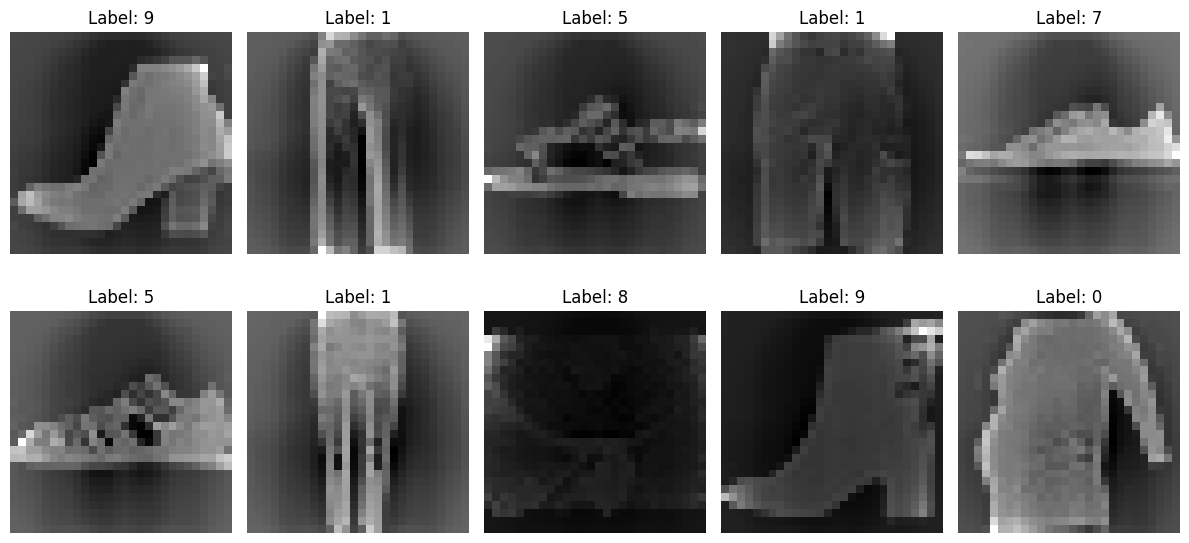

In [68]:
num_images = 10

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(num_images):
    img = X_train[i].reshape(28, 28)
    label = y_train[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()


In [69]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_val = X_val.shape[0]
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))


def one_hot_encode(y, num):
    y_one_hot = np.zeros((10, num))
    y_one_hot[y, np.arange(num)] = 1
    return y_one_hot

y_train_one_hot = one_hot_encode(y_train, num_train)
y_test_one_hot = one_hot_encode(y_test, num_test)
y_val_one_hot = one_hot_encode(y_val, num_val)

In [70]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)
print(y_test_one_hot.shape)

(54000, 784)
(6000, 784)
(10000, 784)
torch.Size([54000])
torch.Size([6000])
torch.Size([10000])
(10, 54000)
(10, 6000)
(10, 10000)


In [71]:
X_train = X_train.T
X_test = X_test.T
X_val = X_val.T

In [72]:
def neural_network(num_hidden, sizes, inputsize=784, outputsize=10, initialization='random'):
    sizes = [inputsize] + sizes
    sizes = sizes + [outputsize]
    
    parameters = {}
    momentum = {}
    
    if initialization == 'xavier':
        for i in range(1, num_hidden + 2):
            parameters["w" + str(i)] = np.random.randn(sizes[i], sizes[i-1]) * np.sqrt(2 / (sizes[i] + sizes[i - 1])) * 0.01
            parameters["b" + str(i)] = np.zeros((sizes[i], 1))
            momentum["w" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
            momentum["b" + str(i)] = np.zeros((sizes[i], 1))
    else:
        for i in range(1, num_hidden + 2):
            parameters["w" + str(i)] = np.random.randn(sizes[i], sizes[i-1]) * 0.01
            parameters["b" + str(i)] = np.zeros((sizes[i], 1))
            momentum["w" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
            momentum["b" + str(i)] = np.zeros((sizes[i], 1))
    
    return parameters, momentum

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return (1 - np.tanh(z)**2)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return 1 * (z > 0)
    
def softmax(z):
    z = z - np.max(z)
    return np.exp(z)/ np.sum(np.exp(z), axis=0)

def softmax_derivative(z):
    return softmax(z) * (1 - softmax(z))

def cross_entropy_loss(y, y_pred, batch_size, weight_decay, parameters):
    
    y_pred_clipped = np.clip(y_pred, 1e-7,1 - 1e-7)
    
    loss = (-1.0 * np.sum(np.multiply(y, np.log(y_pred_clipped + np.exp(-8)))))/batch_size
    
    regularization_loss = 0
    for i in range(1, len(parameters)//2 + 1):
        regularization_loss += np.sum(parameters["w" + str(i)]**2)
    
    loss += (weight_decay/(2 * batch_size)) * regularization_loss 
    
    return loss 

In [73]:
def forward_propagation(X, parameters, activation):
    num_layers = len(parameters)//2
    layer_activations = {
        "sigmoid": sigmoid,
        "relu": relu,
        "tanh": tanh
    }
    if activation not in layer_activations:
        raise ValueError("Invalid Activation Function")
    
    A = [None for _ in range(num_layers + 1)]
    Z = [None for _ in range(num_layers + 1)]
    
    A[0] = X
    for layer in range(1, num_layers + 1):
        Z[layer] = np.dot(parameters["w" + str(layer)], A[layer-1]) + parameters["b" + str(layer)]
        A[layer] = layer_activations[activation](Z[layer])
    output = A[num_layers]
    
    return output, A, Z

def back_propagation(y, A, Z, parameters, activation, batch_size, weight_decay, clip_threshold=1e7):
    
    gradients = {}
    num_layers = len(parameters)//2
    
    gradients["dZ" + str(num_layers)] = A[num_layers] - y
    for layer in range(num_layers, 0, -1):
        dW = np.dot(gradients["dZ" + str(layer)], A[layer - 1].T)
        dW += weight_decay * parameters["w" + str(layer)] / batch_size
        gradients["dW" + str(layer)] = dW
        gradients["db" + str(layer)] = np.sum(gradients["dZ" + str(layer)], axis=1, keepdims=True) / batch_size
        
        if layer > 1:
            dZ = np.matmul(parameters["w" + str(layer)].T, gradients["dZ" + str(layer)])
            if activation == 'relu':
                dZ *= relu_derivative(Z[layer - 1])
            elif activation == 'sigmoid':
                dZ *= sigmoid_derivative(Z[layer - 1])
            elif activation == 'tanh':
                dZ *= tanh_derivative(Z[layer - 1])
            
            dZ = np.clip(dZ, -clip_threshold, clip_threshold)
            
            gradients["dZ" + str(layer - 1)] = dZ
    
    return gradients


In [74]:
def SGD(parameters, grads, learning_rate):
    num_layers = len(parameters) // 2
    
    for layer in range(1, num_layers + 1):
        parameters["w" + str(layer)] -= learning_rate * grads["dW" + str(layer)]
        parameters["b" + str(layer)] -= learning_rate * grads["db" + str(layer)]
    
    return parameters

def momentum(parameters, momentums, grads, beta, learning_rate):
    num_layers = len(parameters) // 2
    
    for layer in range(1, num_layers + 1):
        momentums["w" + str(layer)] = beta * momentums["w" + str(layer)] + learning_rate * grads["dW" + str(layer)]
        parameters["w" + str(layer)] -= momentums["w" + str(layer)]
        
        momentums["b" + str(layer)] = beta * momentums["b" + str(layer)] + learning_rate * grads["db" + str(layer)]
        parameters["b" + str(layer)] -= momentums["b" + str(layer)]
    
    return parameters, momentums

In [75]:
def predict(X_test, parameters, activation):
    y_pred, _, _ = forward_propagation(X_test, parameters, activation=activation)
    predictions = np.argmax(y_pred, axis= 0)
    return predictions

def accuracy(X_train, y_train, X_test, y_test, parameters, activation):
    train_pred = predict(X_train, parameters, activation)
    test_pred = predict(X_test, parameters, activation)
    
    train_accuracy = accuracy_score(y_train, train_pred) * 100
    test_accuracy = accuracy_score(y_test, test_pred) * 100
    return train_accuracy, test_accuracy

def fit(X_train, y_train_one_hot, learning_rate=0.001, activation="relu", initialization="xavier", optimizer="momentum", batch_size=64, epochs=40,
           weight_decay=0.0005, num_neurons=128, num_hidden = 3, beta = 0.9):
    
    sizes = [num_neurons] * num_hidden 
    parameters, momentums = neural_network(num_hidden, sizes, num_features, num_classes, initialization)
    
    for epoch in range(1, epochs + 1):
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = min(batch_size, X_train.shape[1] - i + 1)
            
            if optimizer == "nestrov":
                parameters_lookahead = parameters.copy()
                num_layers = len(parameters) // 2
                
                for layer in range(1, num_layers + 1):
                    parameters_lookahead["w" + str(layer)] = parameters["w" + str(layer)] - beta * momentums["w" + str(layer)]
                    parameters_lookahead["b" + str(layer)] = parameters["b" + str(layer)] - beta * momentums["b" + str(layer)]
                
                _, A, Z = forward_propagation(X_train[:, i: i + batch_count], parameters_lookahead, activation)
                gradients_lookahead = back_propagation(y_train_one_hot[:, i : i + batch_count], A, Z, parameters_lookahead, activation, batch_count, weight_decay)
                
                parameters, momentums = momentum(parameters, momentums, gradients_lookahead, beta, learning_rate)
            else:
                _, A, Z = forward_propagation(X_train[:, i: i + batch_count], parameters, activation)
                gradients = back_propagation(y_train_one_hot[:, i : i + batch_count], A, Z, parameters, activation, batch_count, weight_decay)
                
                if optimizer == "sgd":
                    parameters = SGD(parameters, gradients, learning_rate)
                elif optimizer == "momentum":
                    parameters, momentums = momentum(parameters, momentums, gradients, beta, learning_rate)
        
        y_pred, _, _ = forward_propagation(X_train, parameters, activation)
        cost = cross_entropy_loss(y_train_one_hot, y_pred, num_train, weight_decay, parameters)
        
        if not epoch % 2:
            print("Epoch number: ", epoch, "\tLoss:", cost)
        
    return parameters

In [80]:
learned_parameters = fit(X_train, y_train_one_hot, 
                         learning_rate=0.001,
                         activation="relu",
                         initialization="xavier",
                         optimizer="nestrov", 
                         batch_size=512,
                         epochs=10,
                         weight_decay=0.0005,
                         num_neurons=128,
                         num_hidden=3,
                         beta=0.9)

Epoch number:  2 	Loss: 2.360098908535296
Epoch number:  4 	Loss: 2.2994367070220187
Epoch number:  6 	Loss: 2.2992030656365543
Epoch number:  8 	Loss: 1.5429340059015948
Epoch number:  10 	Loss: 0.4157385450736477


In [81]:
train_accuracy, test_accuracy = accuracy(X_train, y_train, X_test, y_test, learned_parameters, "relu")
print(f"Training accuracy: {train_accuracy} %")
print(f"Test accuracy: {test_accuracy} %")

Training accuracy: 88.61666666666666 %
Test accuracy: 86.22999999999999 %


In [ ]:
def grid_search(X_train, y_train_one_hot, X_val, y_val, num_features, num_classes, learning_rates, activations, initializations, optimizers, batch_sizes, epochs_list, weight_decays, num_neurons_list, num_hidden_list, betas):
    top_5_accuracies = [0] * 5
    top_5_params = [None] * 5
    
    for (learning_rate, activation, initialization, optimizer, batch_size, epochs, weight_decay, num_neurons, num_hidden, beta) in product(learning_rates, activations, initializations, optimizers, batch_sizes, epochs_list, weight_decays, num_neurons_list, num_hidden_list, betas):
        print(f"Training with params: learning_rate={learning_rate}, activation={activation}, initialization={initialization}, optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}, weight_decay={weight_decay}, num_neurons={num_neurons}, num_hidden={num_hidden}, beta={beta}")
        
        parameters = fit(X_train, y_train_one_hot, learning_rate, activation, initialization, optimizer, batch_size, epochs, weight_decay, num_neurons, num_hidden, beta)
        _, val_accuracy = accuracy(X_train, y_train, X_val, y_val, parameters, activation)
        
        for i, (acc, params) in enumerate(zip(top_5_accuracies, top_5_params)):
            if val_accuracy > acc:
                top_5_accuracies.insert(i, val_accuracy)
                top_5_params.insert(i, {
                    "learning_rate": learning_rate,
                    "activation": activation,
                    "initialization": initialization,
                    "optimizer": optimizer,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    "weight_decay": weight_decay,
                    "num_neurons": num_neurons,
                    "num_hidden": num_hidden,
                    "beta": beta
                })
                top_5_accuracies = top_5_accuracies[:5]
                top_5_params = top_5_params[:5]
                break
    
    return top_5_params, top_5_accuracies

epochs_list = [5, 10]
num_hidden_list = [3, 5]
num_neurons_list = [32, 64, 128]
weight_decays = [0, 0.0005, 0.5]
learning_rates = [1e-3, 1e-4]
optimizers = ['sgd', 'momentum', 'nestrov']
batch_sizes = [16, 32, 64]
initializations = ['random', 'xavier']
activations = ['relu', 'sigmoid', 'tanh']
betas = [0.9]

top_5_params, top_5_accuracies = grid_search(X_train, y_train_one_hot, 
                                             X_val, y_val, 
                                             num_features, 
                                             num_classes, 
                                             learning_rates, 
                                             activations, 
                                             initializations, 
                                             optimizers, 
                                             batch_sizes, 
                                             epochs_list,
                                             weight_decays, 
                                             num_neurons_list, 
                                             num_hidden_list, 
                                             betas)


In [ ]:
best_params = top_5_params[0]
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

best_parameters = fit(X_train, y_train_one_hot, **best_params)
test_predictions = predict(X_test, best_parameters, best_params['activation'])
train_accuracy, test_accuracy = accuracy(X_train, y_train, X_test, y_test, best_parameters, best_params['activation'])

conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()